In [1]:
import numpy as np
import matplotlib.pyplot as pl

In [2]:
GM = 4 * np.pi**2 # AU^3 / yr^2

In [3]:
#you won't have my style sheet so don't bother running this cell
pl.style.use("~/Documents/configs/custom.mplstyle")
pl.rcParams['axes.xmargin'] = 0.05

In [39]:
def grav_acc(r, gm=GM):
    '''
    Compute the gravitational acceleration at a position r = [x,y]

    Arguments
    ---------
    r: Numpy array with 2 elements for the x and y coordinates
    gm: (opt) The product of the gravitational constant and the mass of the central object
        This sets the units of the output. Default uses units of AU, Year, M_solar

    Returns
    -------
    a: gravitational acceleration at input coordinates in units set by GM argument
    '''
    r_mag = np.sqrt(np.sum(r**2))
    return -gm / r_mag**3 * r

def energy(x, gm=GM):
    '''
    Compute the total energy (per unit mass) of a particle subject to gravity

    Arguments
    ---------
    x: (2,2) shape Numpy array with containing the position and velocity as [[x,y],[vx,vy]]
    gm: (opt) The product of the gravitational constant and the mass of the central object
        This sets the units of the output. Default uses units of AU, Year, M_solar

    Returns
    -------
    E: the total energy per unit mass of the particle
    '''
    return -gm/np.sqrt(np.sum(x[0]**2)) + np.sum(x[1]**2) / 2

def rp(a, e):
    '''
    Compute the periastron distance of a Keplerian orbit

    Arguments
    ---------
    a: Semi-major axis of the orbit
    e: ellipticity of the orbit

    Returns
    -------
    r_p: periastron distance (clostest approach distance) of the orbit
    '''
    return a*(1-e)

def vp(a, e, gm=GM):
    '''
    Compute the periastron velocity of a Keplerian orbit

    Arguments
    ---------
    a: Semi-major axis of the orbit
    e: ellipticity of the orbit
    gm: (opt) The product of the gravitational constant and the mass of the central object
        This sets the units of the output. Default uses units of AU, Year, M_solar

    Returns
    -------
    r_p: periastron velocity (velocity of closest approach) of the orbit
    '''
    return (gm * (1+e) / a / (1-e))**0.5

def rk_4(x, dt):
    '''
    Using 4th order Runge-Kutta, compute the position and velocity at the next time step
    of an orbit

    Arguments
    ---------
    x: (2,2) shape Numpy array containing the current time step position and velocity 
        in the form [[x,y], [vx, vy]]
    dt: the size of the time step to make when advancing the solution

    Returns
    -------
    x_next: A (2,2) shape Numpy array containing the position and velocity at a 
            time dt after the input step
    '''

    #x[0] refers to the [x y] coordinates
    #x[1] refers to the [vx vy] velocity components

    #these 4 lines implement the standard 4th order Runge-Kutta method
    k1 = dt * np.array([x[1], grav_acc(x[0])])
    k2 = dt * np.array([(x+k1/2)[1], grav_acc((x+k1/2)[0])])
    k3 = dt * np.array([(x+k2/2)[1], grav_acc((x+k2/2)[0])])
    k4 = dt * np.array([(x+k3)[1], grav_acc((x+k3)[0])])

    #returns the updated state
    return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6


def integrate_orbit(method, n, t, r0=None, v0=None, a=1, e=0):
    '''
    Numerically integrate a Keplerian orbit for a given period of time 
    using a given number of discrete steps

    Arguments
    ---------
    method: function for advancing the solution to the next time step
    n: the number of total time steps to break the interval into
    t: the total time to integrate over
       Units set by GM, default is years
    r0: (opt) Length 2 array-like containing the initial position
        If not given, initialized to periastron position for the
         given 'a' and 'e' 
    v0: (opt) Length 2 array-like containing the initial position
        If not given, initialized to periastron velocity for the
         given 'a' and 'e' 
    a: (opt) Semi-major axis of the orbit in units determined by GM, default is 1 AU
    e: (opt) Ellipticity of the orbit; [0,1)
    
    Returns
    -------
    x: A (2,2, n) shape Numpy array containing the position and velocity at all
        n points of the integrated orbit. Format of each element [:,:,i] is [[x,y], [vx,vy]]

    tot_en: (n)-length array containing the total energy (per unit mass) of the particle
            computed at all the discrete points of the integrated orbit
    '''

    #if r0 and v0 are not specified, they are set to defaults
    # using rp and vp
    if not r0 and not v0:
        r0 = [0, rp(a,e)]
        v0 = [-vp(a,e), 0]

    #round in case n is not an integer
    n = round(n)

    #dt is the step size which is the total interval divided
    # by the number of steps
    dt = t/n

    #initialize x and set the initial state
    x = np.zeros((2,2,n+1))
    x[:,:,0] = np.array([r0, v0])

    #iterate over all the steps and set the next state to the updated state
    for i in range(n):
        x[:,:,i+1] = method(x[:,:,i], dt)

    #compute the total energy for all points in the orbit
    tot_en = [energy(x[:,:,i]) for i in range(n)]

    #return the state and total energy arrays
    return x, tot_en


def orbit_adaptive(method, t_end, e_tol=1e-4, dt0=1/1000, r0=None, v0=None, a=1, e=0):
    '''
    Numerically integrate a Keplerian orbit for a given period of time 
    using adaptive time steps

    Arguments
    ---------
    method: function for advancing the solution to the next time step
    t_end: the total time to integrate over
           Units set by GM, default is years
    e_tol: Error tolerance to determine the adaptive step size
           If halving the step size gives an error relative
            to the current time step greater than this, reduce
            step size, otherwise increase step size
    dt0: initial time step size 
         Units determined by GM, default is years
    r0: (opt) Length 2 array-like containing the initial position
        If not given, initialized to periastron position for the
         given 'a' and 'e' 
    v0: (opt) Length 2 array-like containing the initial position
        If not given, initialized to periastron velocity for the
         given 'a' and 'e' 
    a: (opt) Semi-major axis of the orbit in units determined by GM, default is 1 AU
    e: (opt) Ellipticity of the orbit; [0,1)
    
    Returns
    -------
    x: A (2,2, n) shape Numpy array containing the position and velocity at all
        n points of the integrated orbit. Format of each element [:,:,i] is [[x,y], [vx,vy]]

    tot_en: (n)-length array containing the total energy (per unit mass) of the particle
            computed at all the discrete points of the integrated orbit

    ts: (n)-length array containing the times corresponding to each 
        discrete point in the solution
    '''

    #if r0 and v0 are not specified, they are set to defaults
    # using rp and vp
    if not r0 and not v0:
        r0 = [0, rp(a,e)]
        v0 = [-vp(a,e), 0]

    #guess how many steps will be needed based on the 
    # initial step size
    n0 = int(1/dt0)+1

    #initialize the step size
    dt = dt0

    #initialize state and time arrays and set initial state
    x = np.zeros((2,2,n0))
    ts = np.zeros(n0)
    x[:,:,0] = np.array([r0, v0])

    #i keeps track of the index since we are looping until 
    # a time condition is met and we don't know how many
    # steps there will be
    i = 0
    while ts[i] < t_end:

        #check to see if we've exhausted the size of our state and time arrays
        #if so, then double their size and continue
        if (i == len(ts) - 1):
            ts = np.hstack((ts, np.zeros(n0)))
            x = np.concatenate((x, np.zeros((2,2,n0))), axis=2)

        #compute the proposed next state using the given method
        prop_x = method(x[:,:,i], dt)

        #compute the proposed state at +dt using 2 half-steps
        half_x = method(method(x[:,:,i], dt/2), dt/2)

        #compute relative error of full step versus half step in the 
        # position of the particle
        #err = abs(1 - (np.sum(prop_x[0]**2)/np.sum(half_x[0]**2))**0.5)
        err = abs(1 - (np.sum(prop_x.flatten()**2)/np.sum(half_x.flatten()**2))**0.5)

        #if the error is tolerable, then we use the +dt state and 
        # increase the step size
        if err <= e_tol:
            ts[i+1] = ts[i] + dt
            x[:,:,i+1] = prop_x
            dt = dt * (e_tol / err)**0.2
            i+=1

        #if the error is too large, then we decrease the step size and 
        # repeat from the current state
        else:
            dt = dt * (e_tol / err)**0.2
            continue


    #since we are dynamically adjusting the size of the array,
    # we need to remove the unused portion at the end before returning
    mask = np.sum(x, axis=(0,1)) != 0
    x = x[:,:,mask]
    ts = ts[mask]

    #compute the total energy for each state in the orbti
    tot_en = [energy(x[:,:,i]) for i in range(x.shape[2])]

    #return the state, energy, and time arrays
    return x, tot_en, ts


def plot_orbit(s, ax, **kwargs):
    '''
    Helper function to plot integrated orbit trajectories

    Arguments
    ---------
    s: the state vector
    ax: the pyplot axis object on which to plot


    Returns
    -------
    No return, just adds to the given axis
    '''
    x = s[0,0,:].flatten()
    y = s[0,1,:].flatten()
    ax.plot(x,y, **kwargs)
    


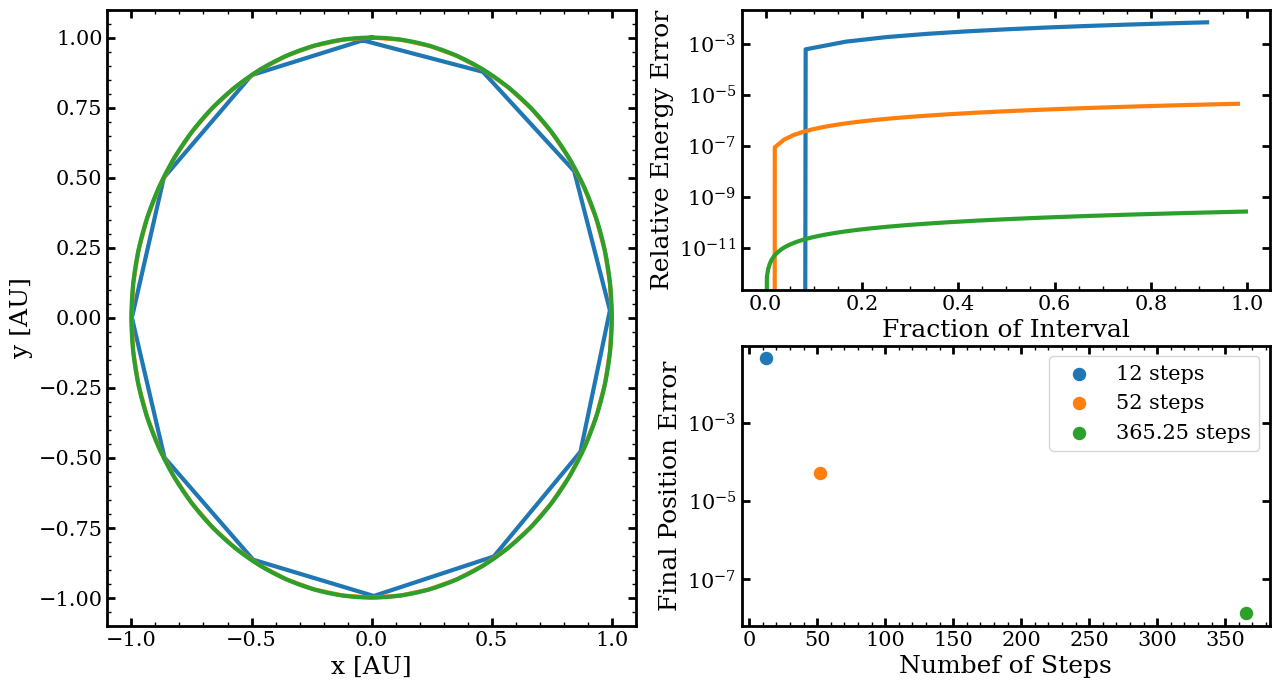

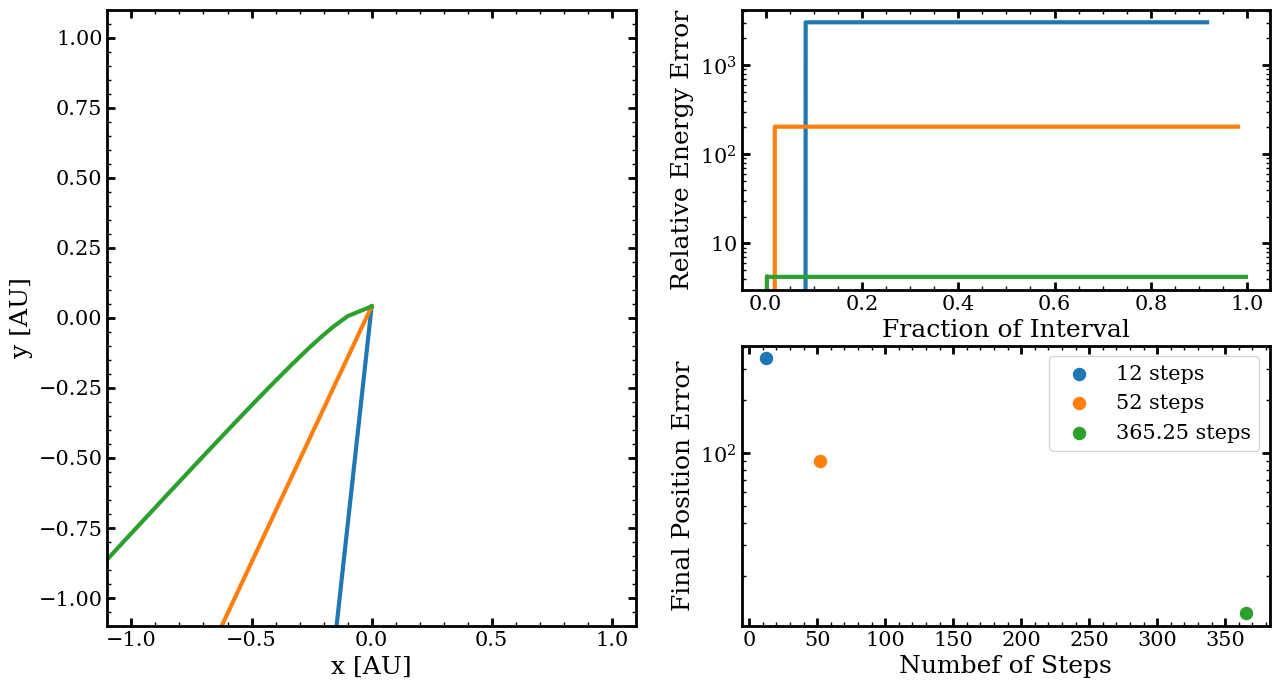

In [25]:
years = 1
ecs = [0,0.96]
for e in ecs:
    intervals = [12, 52, 365.25]
    fig = pl.figure(figsize=(15,8))
    ax1 = pl.subplot(121)
    ax2 = pl.subplot(222)
    ax3 = pl.subplot(224)

    for i in intervals:
        pos, en = integrate_orbit(rk_4, years*i, years, e=e)

        plot_orbit(pos, ax1)
        ax2.plot(np.arange(len(en)) / len(en), abs(en / en[0] - 1))
        ax3.scatter(i, np.sum((pos[0,:,0] - pos[0,:,-1])**2)**0.5, label=f'{i} steps', s=75)

    ax2.set_yscale('log')
    ax3.set_yscale('log')
    ax3.legend()

    ax1.set_xlim(-1.1, 1.1)
    ax1.set_ylim(-1.1, 1.1)


    ax1.set_xlabel("x [AU]")
    ax1.set_ylabel("y [AU]")

    ax2.set_xlabel("Fraction of Interval")
    ax2.set_ylabel("Relative Energy Error")

    ax3.set_xlabel("Numbef of Steps")
    ax3.set_ylabel("Final Position Error")

    pl.show()

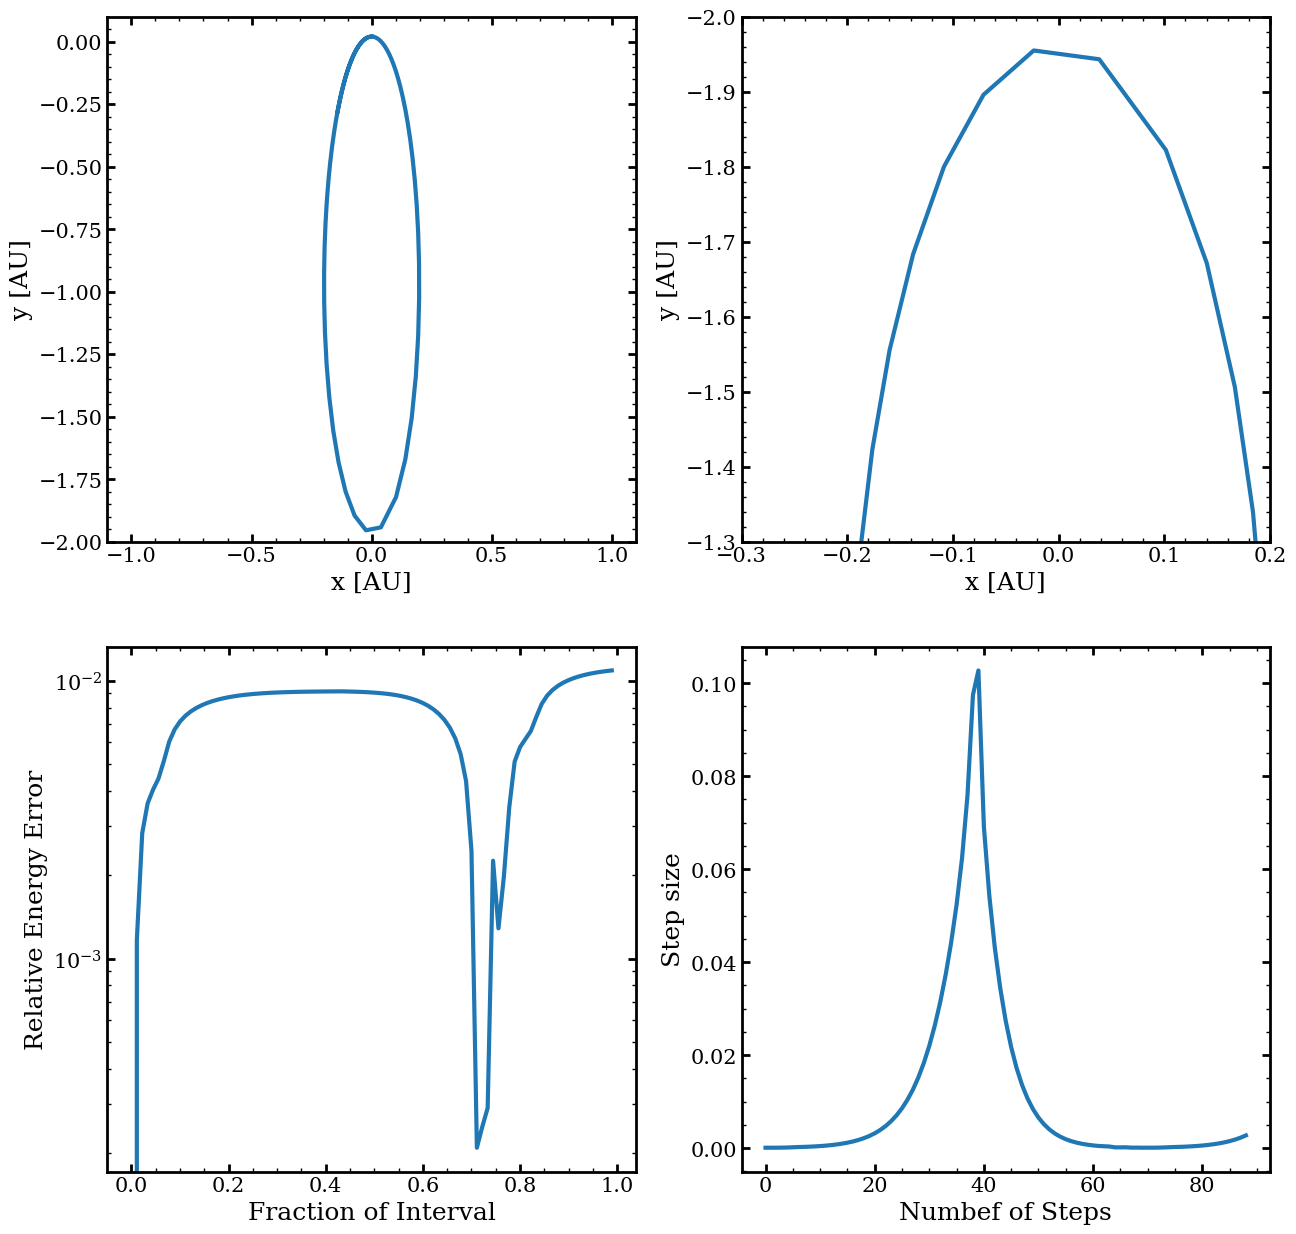

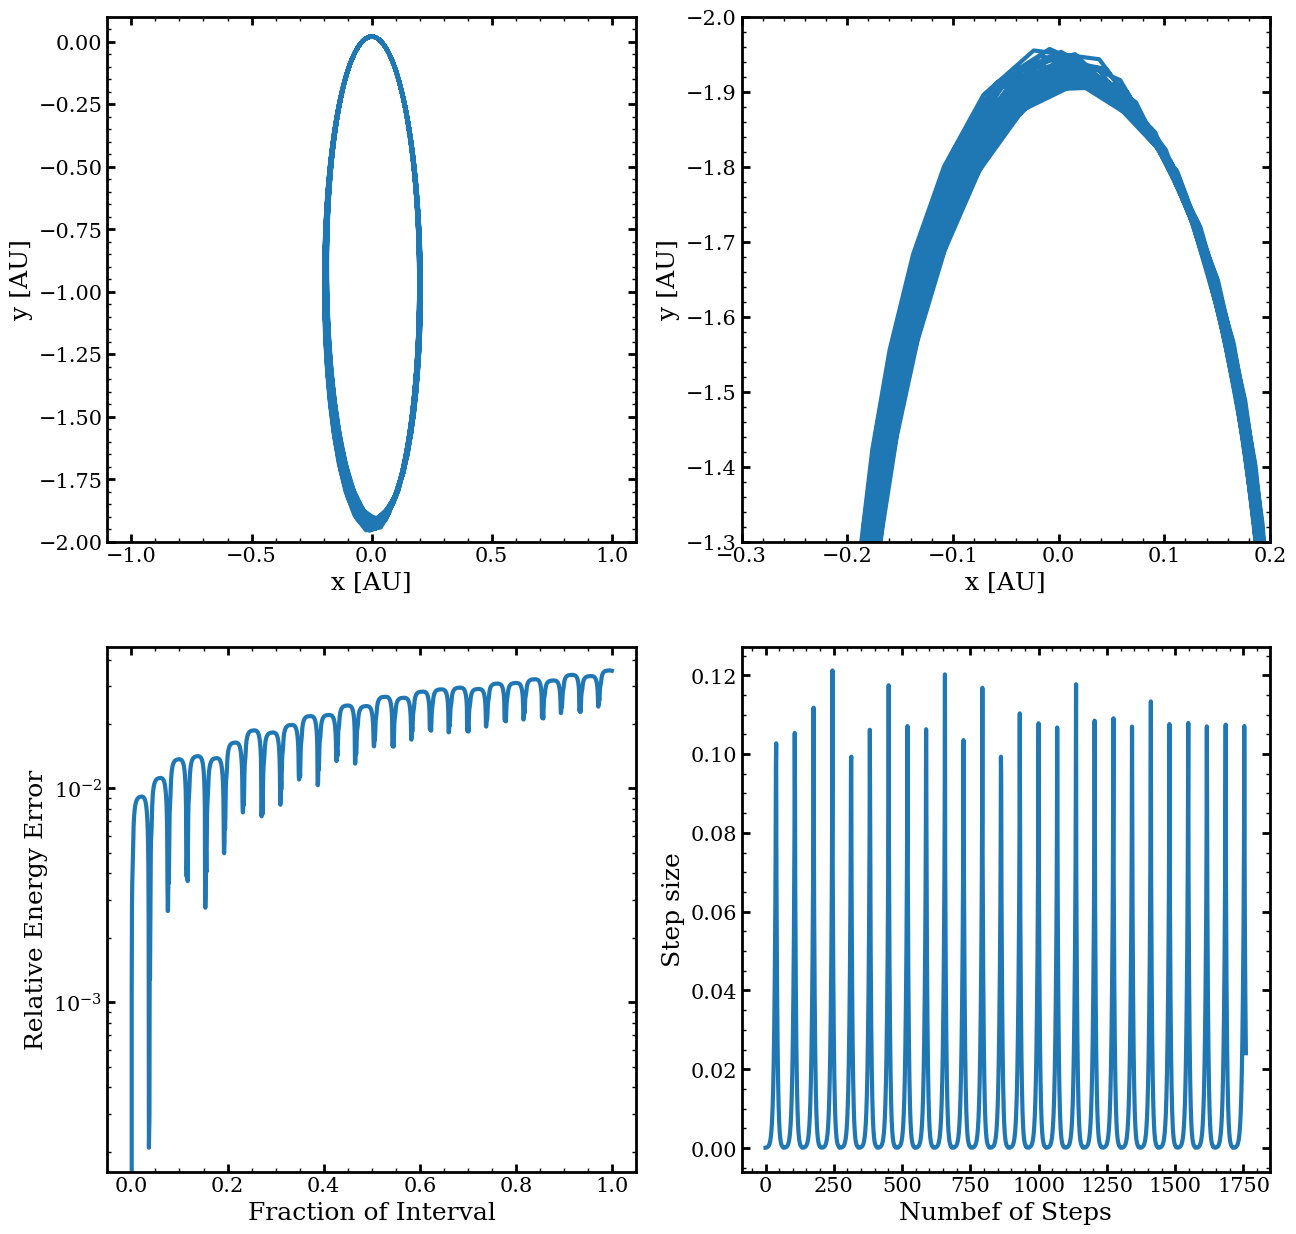

In [40]:
years = [1,25]
e = 0.98

for y in years:    
    fig, ax = pl.subplots(2,2,figsize=(15,15))
    pos, en, ts = orbit_adaptive(rk_4, y, e=e, e_tol=1e-5, dt0=1/12)

    step_size = ts[1:] - ts[:-1]

    plot_orbit(pos, ax[0,0])
    plot_orbit(pos, ax[0,1])

    ax[1,0].plot(np.arange(len(en)) / len(en), abs(en / en[0] - 1))
    ax[1,1].plot(np.arange(len(step_size)), step_size)

    ax[1,0].set_yscale('log')
    ax[1,0].set_yscale('log')

    ax[0,0].set_xlim(-1.1, 1.1)
    ax[0,0].set_ylim(-2, 0.1)

    ax[0,1].set_ylim(-1.3, -2)
    ax[0,1].set_xlim(-0.3, 0.2)

    ax[0,1].set_xlabel("x [AU]")
    ax[0,1].set_ylabel("y [AU]")

    ax[0,0].set_xlabel("x [AU]")
    ax[0,0].set_ylabel("y [AU]")

    ax[1,0].set_xlabel("Fraction of Interval")
    ax[1,0].set_ylabel("Relative Energy Error")

    ax[1,1].set_xlabel("Numbef of Steps")
    ax[1,1].set_ylabel("Step size")

    pl.show()
